In [ ]:
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d misrakahmed/vegetable-image-dataset

 99% 529M/534M [00:03<00:00, 145MB/s]
100% 534M/534M [00:03<00:00, 166MB/s]


In [ ]:
!unzip /content/vegetable-image-dataset.zip

Importing the libraries 

In [ ]:
import os
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score,confusion_matrix


# Tensorflow import
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, ReLU, Softmax, BatchNormalization, Dropout
from tensorflow.random import set_seed

# To supress any warnings during the flow
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mv "/content/drive/MyDrive/ISE Project/Custom_Pictures" "/content/Vegetable Images"

mv: cannot stat '/content/drive/MyDrive/ISE Project/Custom_Pictures': No such file or directory


In [ ]:
#creating dummy folders for custom dataset
for folder in os.listdir('/content/Vegetable Images/train'):
  try:
    os.mkdir('/content/Vegetable Images/Custom_Pictures/'+folder)
  except:
    pass

In [ ]:
!rm -rf "/content/Vegetable Images/Custom_Pictures/.ipynb_checkpoints"

In [ ]:
!rm '/content/Vegetable Images/test/Potato/1040.jpg'

In [ ]:
set_seed(111) # set random seed

#### Explore the data

In [ ]:
class_dirs = os.listdir("/content/Vegetable Images/train")

In [ ]:
class_dirs

['Tomato',
 'Cabbage',
 'Brinjal',
 'Broccoli',
 'Cauliflower',
 'Potato',
 'Pumpkin',
 'Papaya',
 'Capsicum',
 'Bitter_Gourd',
 'Bottle_Gourd',
 'Bean',
 'Carrot',
 'Radish',
 'Cucumber']

In [ ]:
class_dirs = os.listdir("/content/Vegetable Images/train") # list all directories inside "train" folder

image_dict = {} # dict to store image array(key) for every class(value)

count_dict = {} # dict to store count of files(key) for every class(value)

# iterate over all class_dirs
for cls in class_dirs:
    # get list of all paths inside the subdirectory
    file_paths = glob.glob(f'/content/Vegetable Images/train/{cls}/*')
    # count number of files in each class and add it to count_dict
    count_dict[cls] = len(file_paths)
    # select random item from list of image paths
    image_path = random.choice(file_paths)
    # load image using keras utility function and save it in image_dict
    image_dict[cls] = tf.keras.utils.load_img(image_path)

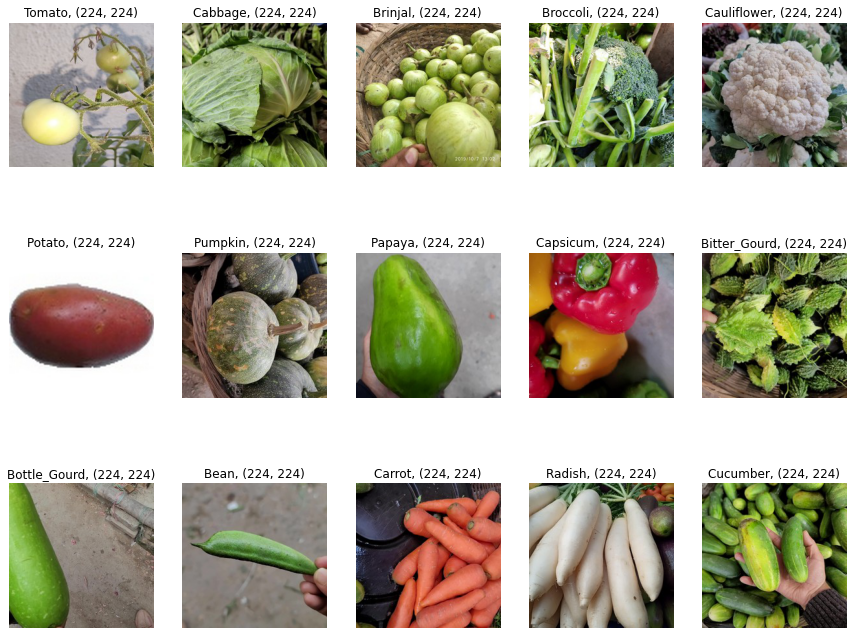

In [ ]:
## Viz Random Sample from each class
plt.figure(figsize=(15, 12))
# iterate over dictionary items (class label, image array)
for i, (cls,img) in enumerate(image_dict.items()): 
    # create a subplot axis
    ax = plt.subplot(3,5,i + 1)
    # plot each image
    plt.imshow(img)
    # set "class name" along with "image size" as title 
    plt.title(f'{cls}, {img.size}')
    plt.axis("off")

In [ ]:
## Let's now Plot the Data Distribution of Training Data across Classes
df_count_train = pd.DataFrame({
    "class": count_dict.keys(),     # keys of count_dict are class labels
    "count": count_dict.values(),   # value of count_dict contain counts of each class
})
print("Count of training samples per class:\n", df_count_train)

Count of training samples per class:
            class  count
0         Tomato   1000
1        Cabbage   1000
2        Brinjal   1000
3       Broccoli   1000
4    Cauliflower   1000
5         Potato   1000
6        Pumpkin   1000
7         Papaya   1000
8       Capsicum   1000
9   Bitter_Gourd   1000
10  Bottle_Gourd   1000
11          Bean   1000
12        Carrot   1000
13        Radish   1000
14      Cucumber   1000


<Figure size 1080x864 with 0 Axes>

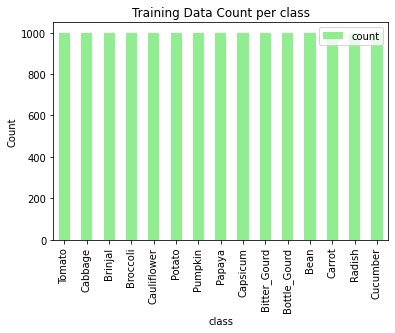

In [ ]:
# draw a bar plot using pandas in-built plotting function

plt.figure(figsize=(15,12))
df_count_train.plot.bar(x='class', y='count', title="Training Data Count per class",color = '#90EE90') 
plt.ylabel('Count')
plt.show()

In [ ]:
#testing data
count_dict_test_data = {} # dict to store count of files(key) for every class(value)

# iterate over all class_dirs
for cls in os.listdir('/content/Vegetable Images/test'):
    # get list of all paths inside the subdirectory
    file_paths = glob.glob(f'/content/Vegetable Images/test/{cls}/*')
    # count number of files in each class and add it to count_dict
    count_dict_test_data[cls] = len(file_paths)



<Figure size 1080x864 with 0 Axes>

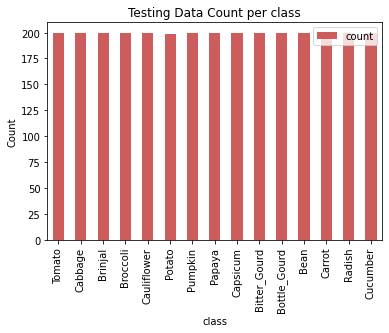

In [ ]:
df_count_test = pd.DataFrame({
    "class": count_dict_test_data.keys(),     # keys of count_dict are class labels
    "count": count_dict_test_data.values(),   # value of count_dict contain counts of each class
})

# draw a bar plot using pandas in-built plotting function

plt.figure(figsize=(15,12))
df_count_test.plot.bar(x='class', y='count', title="Testing Data Count per class",color = 'indianred') 
plt.ylabel('Count')
plt.show()

In [ ]:
#validation data

#testing data
count_dict_valid_data = {} # dict to store count of files(key) for every class(value)

# iterate over all class_dirs
for cls in os.listdir('/content/Vegetable Images/validation'):
    # get list of all paths inside the subdirectory
    file_paths = glob.glob(f'/content/Vegetable Images/test/{cls}/*')
    # count number of files in each class and add it to count_dict
    count_dict_valid_data[cls] = len(file_paths)

<Figure size 1080x864 with 0 Axes>

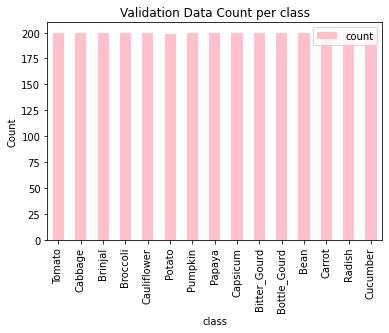

In [ ]:
df_count_valid = pd.DataFrame({
    "class": count_dict_valid_data.keys(),     # keys of count_dict are class labels
    "count": count_dict_valid_data.values(),   # value of count_dict contain counts of each class
})

# draw a bar plot using pandas in-built plotting function

plt.figure(figsize=(15,12))
df_count_valid.plot.bar(x='class', y='count', title="Validation Data Count per class",color = 'pink') 
plt.ylabel('Count')
plt.show()

Loading Data


In [ ]:
print('\nLoading Train Data...')
train_data = tf.keras.utils.image_dataset_from_directory(
    "/content/Vegetable Images/train", shuffle = True,
)

print('\nLoading Validation Data...')
val_data = tf.keras.utils.image_dataset_from_directory(
    "/content/Vegetable Images/validation", shuffle = False,
)

print('\nLoading Test Data...')
test_data = tf.keras.utils.image_dataset_from_directory(
    "/content/Vegetable Images/test", shuffle = False,
)

print('\nLoading Custom Data...')
custom_data = tf.keras.utils.image_dataset_from_directory(
    "/content/Vegetable Images/Custom_Pictures", shuffle = False
)


Loading Train Data...
Found 15000 files belonging to 15 classes.

Loading Validation Data...
Found 3000 files belonging to 15 classes.

Loading Test Data...
Found 2999 files belonging to 15 classes.

Loading Custom Data...
Found 33 files belonging to 15 classes.


Below are few of the images from our custom dataset.

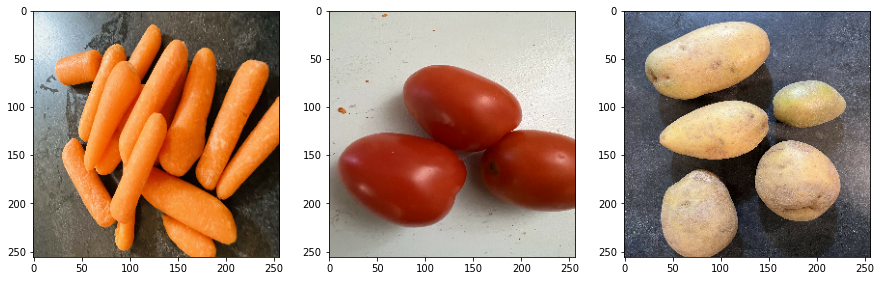

In [ ]:
image1,label1 = next(iter(custom_data))

plt.figure(figsize=(15, 12))
plt.subplot(1,3,1)
plt.imshow(image1[1].numpy().astype("uint8"))

plt.subplot(1,3,2)
plt.imshow(image1[30].numpy().astype("uint8"))

plt.subplot(1,3,3)
plt.imshow(image1[20].numpy().astype("uint8"))

plt.show()

# Data Preprocessing

In [ ]:
height, width = 224, 224

# Data Processing Stage with resizing and rescaling operations
data_preprocess = keras.Sequential(
    name="data_preprocess",
    layers=[
        layers.Resizing(height, width), # Shape Preprocessing
        layers.Rescaling(1.0/255), # Value Preprocessing
    ]
)

# Perform Data Processing on the train, val, test dataset
train_ds = train_data.map(lambda x, y: (data_preprocess(x),y))
val_ds = val_data.map(lambda x, y: (data_preprocess(x),y))
test_ds = test_data.map(lambda x, y: (data_preprocess(x), y))
custom_ds = custom_data.map(lambda x,y: (data_preprocess(x),y))

In [ ]:
num_classes = 15
hidden_size_1 = 1024
hidden_size_2 = 256

Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [ ]:
image,label = next(iter(train_data))

In [ ]:
# Add the image to a batch.
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

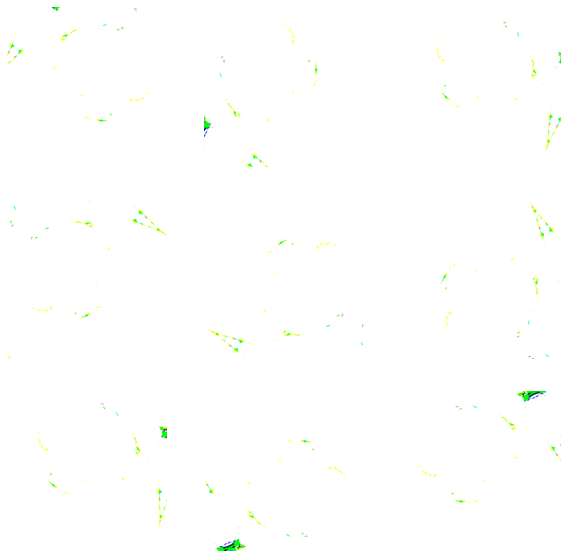

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image[0])
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

Functions for performance metrics and plotting

In [ ]:
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])
    
def ConfusionMatrix(model, ds, label_list):
# Note: This logic doesn't work with shuffled datasets
    plt.figure(figsize=(15,15))
    y_pred = model.predict(ds)
    predicted_categories = tf.argmax(y_pred, axis=1)
    true_categories = tf.concat([y for x, y in ds], axis=0)
    cm = confusion_matrix(true_categories,predicted_categories) # last batch 
    sns.heatmap(cm, annot=True, xticklabels=label_list, yticklabels=label_list, cmap="YlGnBu", fmt='g')
    plt.show()
    
def testAccuracy(model,data):
    true_categories = tf.concat([y for x, y in data], axis=0)
    images = tf.concat([x for x, y in data], axis=0)
    y_pred = model.predict(data)
    # class_names = data.class_names
    predicted_categories = tf.argmax(y_pred, axis=1)
    # print(predicted_categories)
    # print(true_categories,'True categories')
    test_acc = accuracy_score(true_categories, predicted_categories) * 100
    print(f'\nTest Accuracy: {test_acc:.2f}%\n')
    
def plot_image(pred_array, true_label, img, class_names):
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(pred_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ".format(class_names[predicted_label],
                                100*np.max(pred_array),
                                ),
                                color=color)

#dataset->test_data
#data->test_ds
def predictions(model,dataset,data):
    true_categories = tf.concat([y for x, y in data], axis=0)
    images = tf.concat([x for x, y in data], axis=0)
    y_pred = model.predict(data)
    class_names = dataset.class_names
    # Randomly sample 15 test images and plot it with their predicted labels, and the true labels.
    indices = random.sample(range(len(images)), 15)
    # Color correct predictions in blue and incorrect predictions in red.
    num_rows = 5
    num_cols = 3
    num_images = num_rows*num_cols
    plt.figure(figsize=(4*num_cols, 2*num_rows))
    for i,index in enumerate(indices):
      plt.subplot(num_rows, num_cols, i+1)
      plot_image(y_pred[index], true_categories[index], images[index],class_names)
    plt.tight_layout()
    plt.show()

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint("final_model.h5", save_best_only=True)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",patience=5, restore_best_weights=True
)

# Baseline Model

Training Baseline CNN Model

In [ ]:
model_base_cnn = keras.Sequential(
    name="model_base_cnn",
    layers=[
        layers.Conv2D(filters=16, kernel_size=3, strides=1, padding="same", activation='relu', input_shape=(height, width, 3)),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(units=256, activation='relu'),
        layers.Dense(units=num_classes, activation='softmax')
    ]
)

In [ ]:
model_base_cnn.summary()

Model: "model_base_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 256)               51380480  
                                                                 
 dense_1 (Dense)             (None, 15)                3855      
                                                                 
Total params: 51,384,783
Trainable params: 51,384,783
Non-trainable params: 0
________________________________________

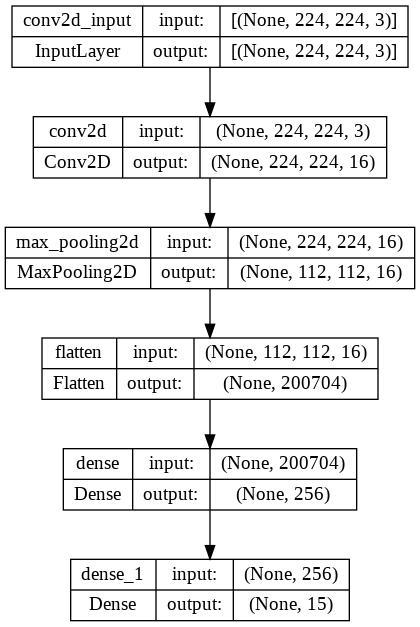

In [ ]:
tf.keras.utils.plot_model(model_base_cnn, to_file="model_cnn.png", show_shapes=True)

In [ ]:
#compiling the model
model_base_cnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
#fit the model
epochs = 20
model_base_cnn_fit = model_base_cnn.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20
469/469 [==============================] - 44s 79ms/step - loss: 1.7984 - accuracy: 0.6037 - val_loss: 0.7174 - val_accuracy: 0.7823
Epoch 2/20
469/469 [==============================] - 37s 79ms/step - loss: 0.3916 - accuracy: 0.8891 - val_loss: 0.4612 - val_accuracy: 0.8577
Epoch 3/20
469/469 [==============================] - 37s 79ms/step - loss: 0.1668 - accuracy: 0.9556 - val_loss: 0.4419 - val_accuracy: 0.8737
Epoch 4/20
469/469 [==============================] - 37s 78ms/step - loss: 0.0781 - accuracy: 0.9813 - val_loss: 0.5209 - val_accuracy: 0.8567
Epoch 5/20
469/469 [==============================] - 37s 78ms/step - loss: 0.0415 - accuracy: 0.9901 - val_loss: 0.6218 - val_accuracy: 0.8410
Epoch 6/20
469/469 [==============================] - 36s 76ms/step - loss: 0.0527 - accuracy: 0.9870 - val_loss: 0.6266 - val_accuracy: 0.8560
Epoch 7/20
469/469 [==============================] - 37s 77ms/step - loss: 0.0431 - accuracy: 0.9882 - val_loss: 0.6817 - val_accuracy:

Text(0.5, 1.0, 'Baseline CNN: loss and Accuracy')

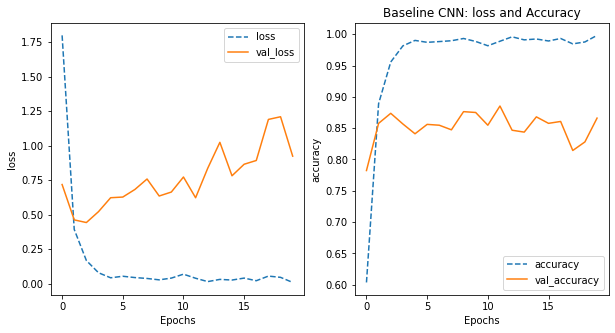

In [ ]:
#training plot 
training_plot(['loss', 'accuracy'], model_base_cnn_fit)
plt.title('Baseline CNN: loss and Accuracy')

In [ ]:
#with test data
testAccuracy(model_base_cnn,test_ds)

94/94 [==============================] - 5s 57ms/step

Test Accuracy: 87.23%



In [ ]:
#with custom data
testAccuracy(model_base_cnn,custom_ds)

2/2 [==============================] - 2s 50ms/step

Test Accuracy: 42.42%



94/94 [==============================] - 5s 57ms/step


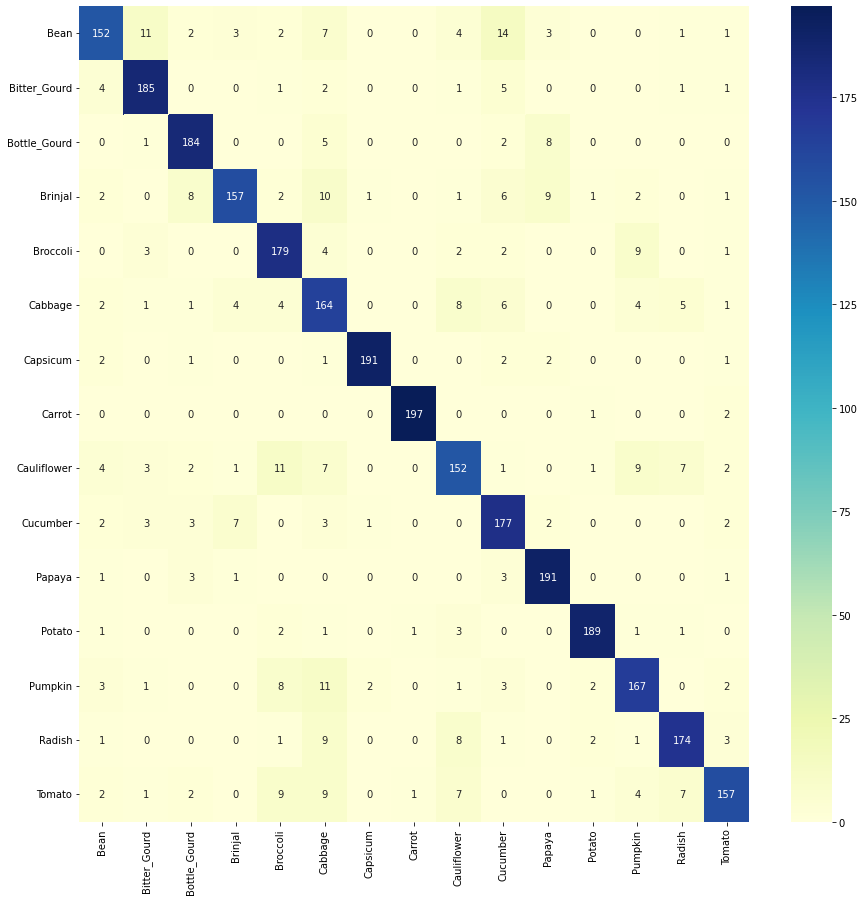

In [ ]:
ConfusionMatrix(model_base_cnn, test_ds, test_data.class_names)

2/2 [==============================] - 2s 54ms/step


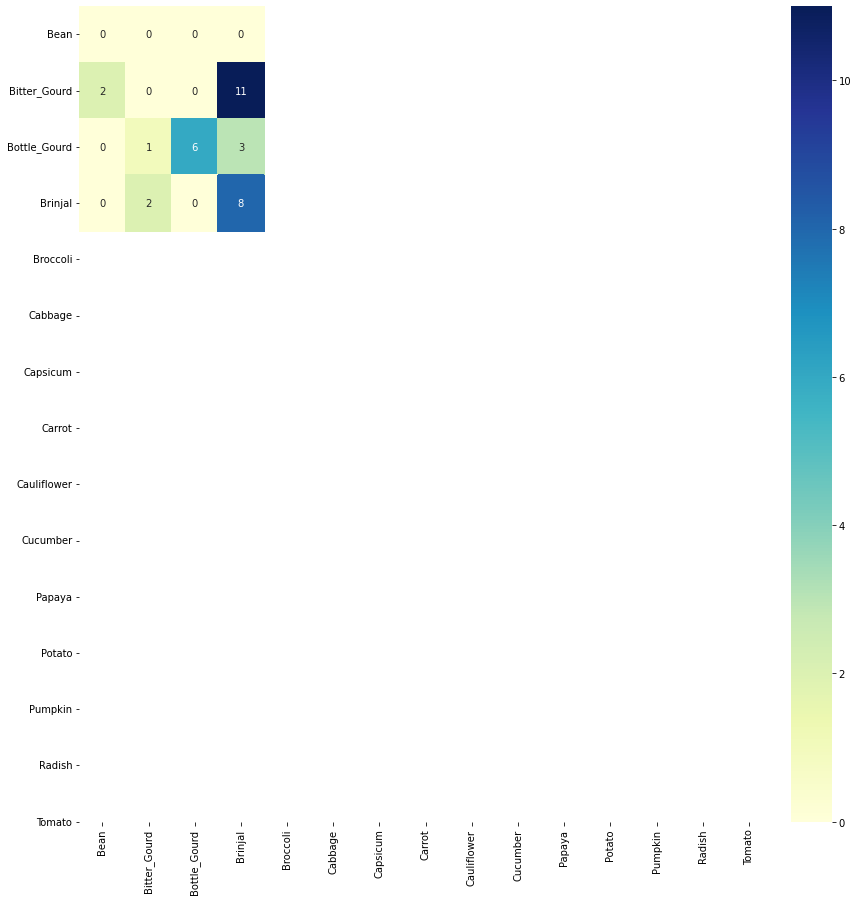

In [ ]:
ConfusionMatrix(model_base_cnn, custom_ds, custom_data.class_names)

Baseline model with Data Augmentation

In [ ]:
model_base_cnn_da = keras.Sequential(
    name="model_base_cnn",
    layers=[
        data_augmentation,
        layers.Conv2D(filters=16, kernel_size=3, strides=1, padding="same", activation='relu', input_shape=(height, width, 3)),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(units=256, activation='relu'),
        layers.Dense(units=num_classes, activation='softmax')
    ]
)

In [ ]:
model_base_cnn_da.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
epochs = 20
model_base_cnn_da_fit = model_base_cnn_da.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20
469/469 [==============================] - 49s 101ms/step - loss: 4.2751 - accuracy: 0.2185 - val_loss: 2.0295 - val_accuracy: 0.3653
Epoch 2/20
469/469 [==============================] - 47s 100ms/step - loss: 1.7721 - accuracy: 0.4234 - val_loss: 1.5155 - val_accuracy: 0.5060
Epoch 3/20
469/469 [==============================] - 48s 101ms/step - loss: 1.3222 - accuracy: 0.5577 - val_loss: 1.1562 - val_accuracy: 0.6300
Epoch 4/20
469/469 [==============================] - 47s 99ms/step - loss: 1.1252 - accuracy: 0.6269 - val_loss: 1.0074 - val_accuracy: 0.6687
Epoch 5/20
469/469 [==============================] - 47s 100ms/step - loss: 0.9678 - accuracy: 0.6787 - val_loss: 0.9981 - val_accuracy: 0.6707
Epoch 6/20
469/469 [==============================] - 46s 98ms/step - loss: 0.9112 - accuracy: 0.6995 - val_loss: 0.8683 - val_accuracy: 0.7237
Epoch 7/20
469/469 [==============================] - 47s 100ms/step - loss: 0.8219 - accuracy: 0.7323 - val_loss: 0.8716 - val_accu

In [ ]:
testAccuracy(model_base_cnn_da,test_ds)

94/94 [==============================] - 6s 65ms/step

Test Accuracy: 89.27%



In [ ]:
testAccuracy(model_base_cnn_da,custom_ds)

Improving Baseline, Creating deeper model

In [ ]:
model_impv_cnn = keras.Sequential(
    name="model_impv_cnn_2",
    layers=[
        layers.Conv2D(filters=64, kernel_size=3, strides=1, padding="same", activation='relu', input_shape=(height, width, 3)),
        layers.Conv2D(filters=64, kernel_size=3, strides=1, padding="same", activation='relu', input_shape=(height, width, 3)),
        layers.MaxPooling2D(),
        layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same", activation='relu', input_shape=(height, width, 3)),
        layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same", activation='relu', input_shape=(height, width, 3)),
        layers.MaxPooling2D(),
        layers.Conv2D(filters=16, kernel_size=3, strides=1, padding="same", activation='relu', input_shape=(height, width, 3)),
        layers.Conv2D(filters=16, kernel_size=3, strides=1, padding="same", activation='relu', input_shape=(height, width, 3)),
        layers.MaxPooling2D(),
        layers.GlobalAveragePooling2D(),
        layers.Dense(units=num_classes, activation='softmax')
    ]
)

In [ ]:
model_impv_cnn.summary()

Model: "model_impv_cnn_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 conv2d_2 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 32)      18464     
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                              

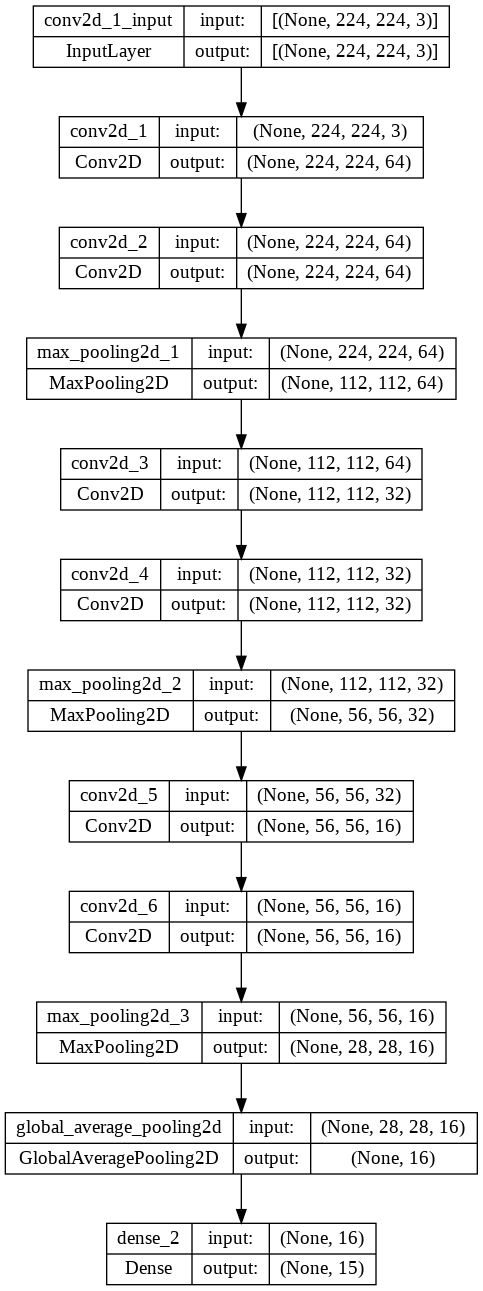

In [ ]:
tf.keras.utils.plot_model(model_impv_cnn, to_file="model_cnn_2.png", show_shapes=True)

In [ ]:
model_impv_cnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
epochs = 25
model_fit = model_impv_cnn.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/25
469/469 [==============================] - 83s 169ms/step - loss: 2.1590 - accuracy: 0.2629 - val_loss: 1.5721 - val_accuracy: 0.4570
Epoch 2/25
469/469 [==============================] - 79s 167ms/step - loss: 1.4426 - accuracy: 0.5297 - val_loss: 1.3358 - val_accuracy: 0.5490
Epoch 3/25
469/469 [==============================] - 83s 176ms/step - loss: 1.1739 - accuracy: 0.6186 - val_loss: 1.0599 - val_accuracy: 0.6713
Epoch 4/25
469/469 [==============================] - 79s 168ms/step - loss: 0.8818 - accuracy: 0.7175 - val_loss: 1.0449 - val_accuracy: 0.7050
Epoch 5/25
469/469 [==============================] - 83s 177ms/step - loss: 0.7151 - accuracy: 0.7809 - val_loss: 0.6494 - val_accuracy: 0.8210
Epoch 6/25
469/469 [==============================] - 79s 168ms/step - loss: 0.5956 - accuracy: 0.8189 - val_loss: 0.5923 - val_accuracy: 0.8430
Epoch 7/25
469/469 [==============================] - 79s 168ms/step - loss: 0.5063 - accuracy: 0.8478 - val_loss: 0.4651 - val_ac

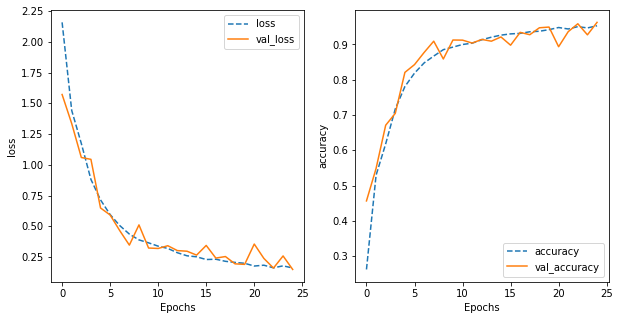

In [ ]:
training_plot(['loss', 'accuracy'], model_fit)

In [ ]:
testAccuracy(model_impv_cnn)

94/94 [==============================] - 7s 70ms/step

Test Accuracy: 96.23%



In [ ]:
ConfusionMatrix(model_impv_cnn,test_ds,test_data.class_names)

**Further Improving Baseline Model**

Reducing the overfitting of the model using BatchNormalization and Dropout layers. Adding Global Average Pooling instead of Flatten layer.

In [ ]:
model_bndr_cnn = keras.Sequential(
    name="model_cnn_4",
    layers=[
        layers.Conv2D(filters=64, kernel_size=3, strides=1, padding="same", activation='relu', input_shape=(height, width, 3)),
        layers.Conv2D(filters=64, kernel_size=3, strides=1, padding="same", activation='relu', input_shape=(height, width, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same", activation='relu', input_shape=(height, width, 3)),
        layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same", activation='relu', input_shape=(height, width, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Conv2D(filters=16, kernel_size=3, strides=1, padding="same", activation='relu', input_shape=(height, width, 3)),
        layers.Conv2D(filters=16, kernel_size=3, strides=1, padding="same", activation='relu', input_shape=(height, width, 3)),
        layers.MaxPooling2D(),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.25),
        layers.Dense(units=num_classes, activation='softmax')
    ]
)

In [ ]:
model_bndr_cnn.summary()

Model: "model_cnn_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 conv2d_8 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 batch_normalization_2 (Batc  (None, 224, 224, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 112, 112, 32)      18464     
                                                                 
 conv2d_10 (Conv2D)          (None, 112, 112, 32)      

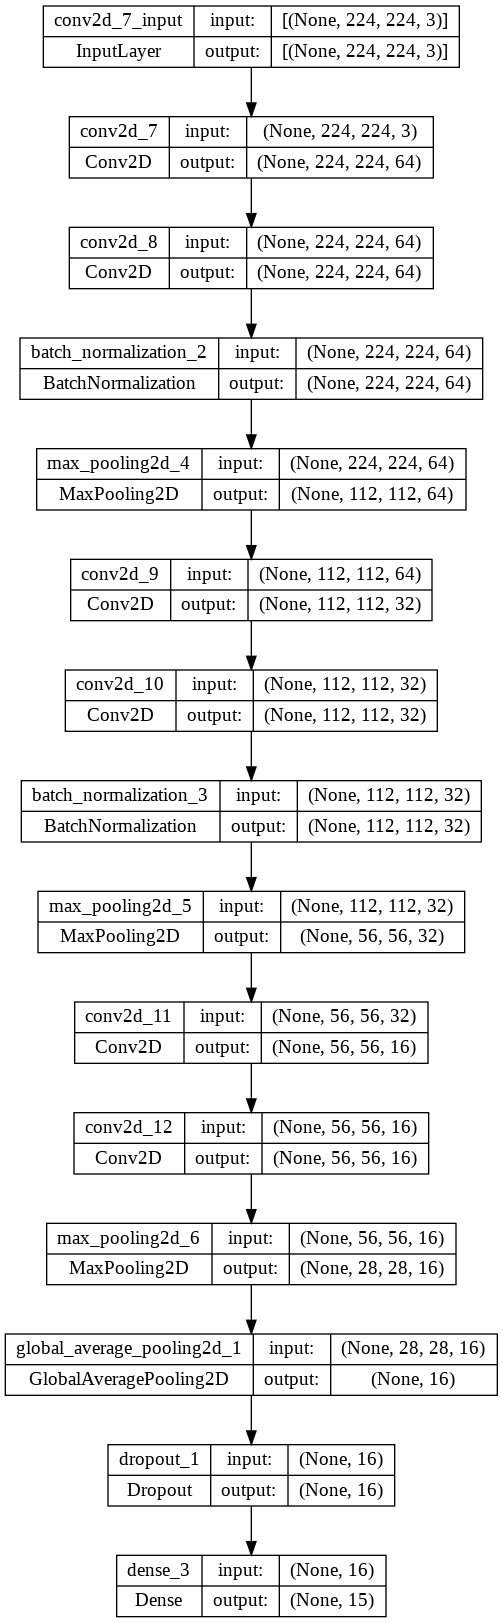

In [ ]:
tf.keras.utils.plot_model(model_bndr_cnn, to_file="model_cnn_3.png", show_shapes=True)

In [ ]:
model_bndr_cnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Callbacks in Keras

from keras.callbacks import ModelCheckpoint
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='model_bndr_cnn.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [ ]:
epochs = 25
model_bndr_cnn_fit = model_bndr_cnn.fit(train_ds, validation_data=val_ds, epochs=epochs,
                                        callbacks=my_callbacks)

Epoch 1/25
469/469 [==============================] - 93s 198ms/step - loss: 1.8811 - accuracy: 0.3892 - val_loss: 1.6375 - val_accuracy: 0.4463
Epoch 2/25
469/469 [==============================] - 88s 187ms/step - loss: 1.3824 - accuracy: 0.5485 - val_loss: 1.9916 - val_accuracy: 0.3837
Epoch 3/25
469/469 [==============================] - 88s 186ms/step - loss: 1.0944 - accuracy: 0.6446 - val_loss: 0.7656 - val_accuracy: 0.7813
Epoch 4/25
469/469 [==============================] - 88s 186ms/step - loss: 0.9421 - accuracy: 0.6969 - val_loss: 4.6926 - val_accuracy: 0.2763
Epoch 5/25
469/469 [==============================] - 88s 186ms/step - loss: 0.8262 - accuracy: 0.7371 - val_loss: 0.4478 - val_accuracy: 0.8770
Epoch 6/25
469/469 [==============================] - 88s 187ms/step - loss: 0.7226 - accuracy: 0.7685 - val_loss: 0.4309 - val_accuracy: 0.8823
Epoch 7/25
469/469 [==============================] - 88s 186ms/step - loss: 0.6687 - accuracy: 0.7841 - val_loss: 0.8085 - val_ac

In [ ]:
training_plot(['loss', 'accuracy'], model_bndr_cnn_fit)

In [ ]:
testAccuracy(model_bndr_cnn)

In [ ]:
ConfusionMatrix(model_bndr_cnn, test_ds, test_data.class_names)

# Transfer Learning

## VGG

In [ ]:
pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=[height,width, 3])
pretrained_model.trainable=False
vgg16_model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(15, activation='softmax')
])

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
vgg16_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 64)                32832     
                                                                 
 dense_5 (Dense)             (None, 15)                975       
                                                                 
Total params: 14,748,495
Trainable params: 33,807
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
vgg16_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# change to 50 epochs
history_vgg16 = vgg16_model.fit(train_ds, epochs=5, validation_data=val_ds,
                                callbacks=my_callbacks)

Epoch 1/5
469/469 [==============================] - 94s 198ms/step - loss: 0.5087 - accuracy: 0.8877 - val_loss: 0.3278 - val_accuracy: 0.9323
Epoch 2/5
469/469 [==============================] - 97s 206ms/step - loss: 0.2660 - accuracy: 0.9434 - val_loss: 0.2164 - val_accuracy: 0.9537
Epoch 3/5
469/469 [==============================] - 92s 195ms/step - loss: 0.1786 - accuracy: 0.9639 - val_loss: 0.1509 - val_accuracy: 0.9690
Epoch 4/5
469/469 [==============================] - 97s 207ms/step - loss: 0.1309 - accuracy: 0.9740 - val_loss: 0.1189 - val_accuracy: 0.9757
Epoch 5/5
469/469 [==============================] - 97s 207ms/step - loss: 0.1029 - accuracy: 0.9771 - val_loss: 0.0959 - val_accuracy: 0.9800


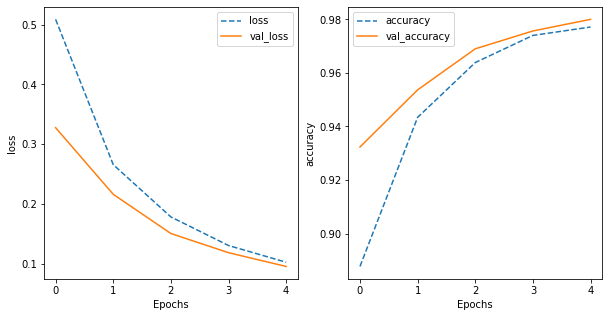

In [ ]:
training_plot(['loss', 'accuracy'], history_vgg16)

In [ ]:
testAccuracy(vgg16_model)

94/94 [==============================] - 15s 158ms/step

Test Accuracy: 98.00%



94/94 [==============================] - 15s 162ms/step


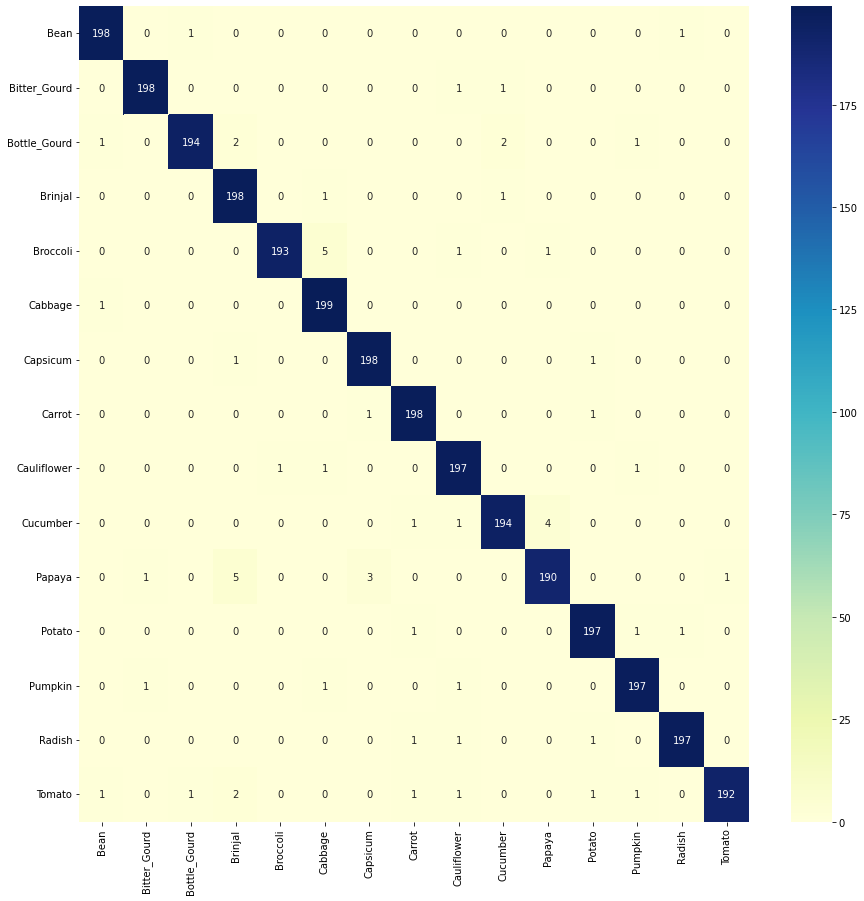

In [ ]:
ConfusionMatrix(vgg16_model, test_ds, test_data.class_names)

## RESNET

In [ ]:
pretrained_resnet_model = tf.keras.applications.ResNet50V2(weights='imagenet',
                         include_top=False,
                         input_tensor = (tf.keras.layers.Input(shape=(height,width,3)))
                         )
pretrained_resnet_model.trainable=False
resnet_model = tf.keras.Sequential([
    pretrained_resnet_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(15, activation='softmax')
])

94668760/94668760 [==============================] - 6s 0us/step


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 15)                30735     
                                                                 
Total params: 23,595,535
Trainable params: 30,735
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
resnet_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# epochs = 25
history_resnet = resnet_model.fit(train_ds, epochs=5, validation_data=val_ds, 
                                  callbacks=my_callbacks)

Epoch 1/5
469/469 [==============================] - 66s 117ms/step - loss: 0.1820 - accuracy: 0.9571 - val_loss: 0.0351 - val_accuracy: 0.9950
Epoch 2/5
469/469 [==============================] - 55s 116ms/step - loss: 0.0197 - accuracy: 0.9973 - val_loss: 0.0204 - val_accuracy: 0.9963
Epoch 3/5
469/469 [==============================] - 52s 110ms/step - loss: 0.0087 - accuracy: 0.9990 - val_loss: 0.0132 - val_accuracy: 0.9967
Epoch 4/5
469/469 [==============================] - 55s 117ms/step - loss: 0.0048 - accuracy: 0.9997 - val_loss: 0.0121 - val_accuracy: 0.9967
Epoch 5/5
469/469 [==============================] - 52s 110ms/step - loss: 0.0031 - accuracy: 0.9999 - val_loss: 0.0111 - val_accuracy: 0.9967


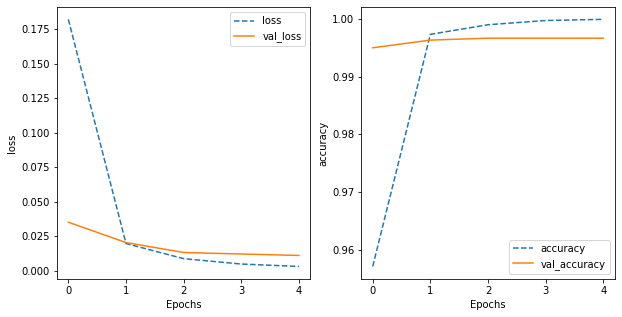

In [ ]:
training_plot(['loss', 'accuracy'], history_resnet)

In [ ]:
testAccuracy(resnet_model,test_ds)

94/94 [==============================] - 9s 92ms/step
tf.Tensor([ 0  0  0 ... 14 14 14], shape=(3000,), dtype=int64)
tf.Tensor([ 0  0  0 ... 14 14 14], shape=(3000,), dtype=int32) True categories

Test Accuracy: 99.73%



In [ ]:
testAccuracy(resnet_model,custom_ds)

2/2 [==============================] - 2s 584ms/step
tf.Tensor(
[ 7  7  7  9  7  7  7  7  7  7  7  7  7 11 11 11 11 11 11 11 11 11 11 14
 14 14 14 11 14 14 14 14 14], shape=(33,), dtype=int64)
tf.Tensor(
[ 7  7  7  7  7  7  7  7  7  7  7  7  7 11 11 11 11 11 11 11 11 11 11 14
 14 14 14 14 14 14 14 14 14], shape=(33,), dtype=int32) True categories

Test Accuracy: 93.94%



94/94 [==============================] - 8s 88ms/step


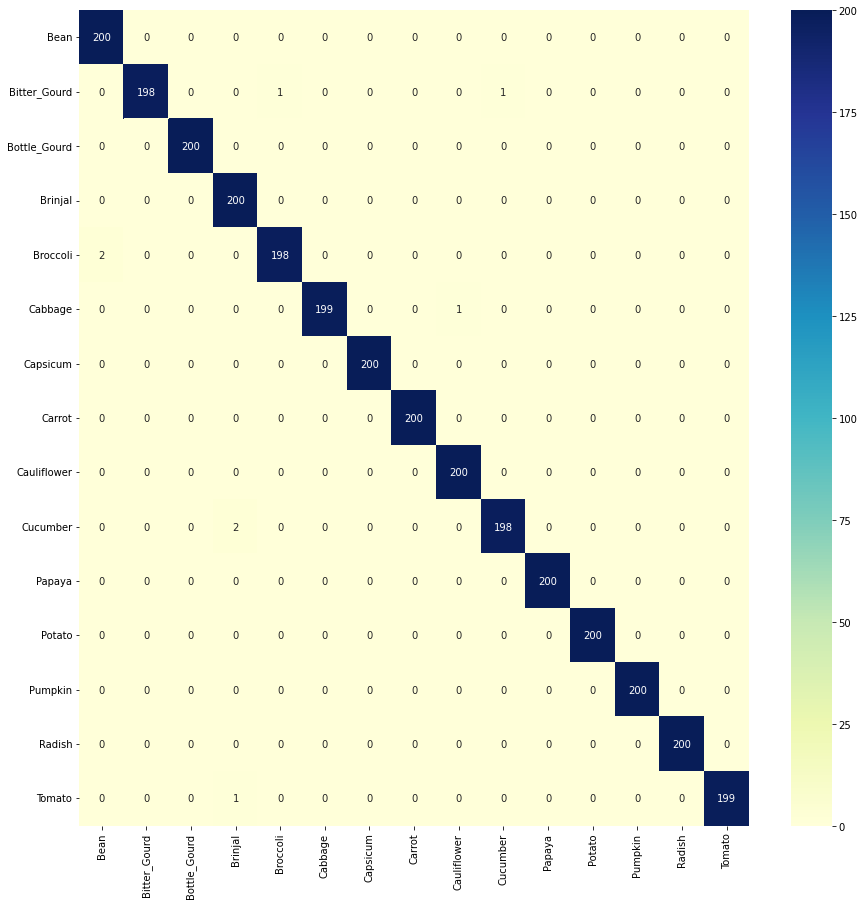

In [ ]:
ConfusionMatrix(resnet_model, test_ds, test_data.class_names)

## MobileNet


In [ ]:

pretrained_mobilenet_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=[height,width, 3])
pretrained_mobilenet_model.trainable=False
mobilenet_model = tf.keras.Sequential([
    pretrained_mobilenet_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(15, activation='softmax')
])

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
mobilenet_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
mobilenet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_5   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 15)                19215     
                                                                 
Total params: 2,277,199
Trainable params: 19,215
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
# epoch = 10
history_mobilenet = mobilenet_model.fit(train_ds, epochs=5, validation_data=val_ds, 
                                        callbacks=my_callbacks)

Epoch 1/5
469/469 [==============================] - 35s 74ms/step - loss: 0.0096 - accuracy: 0.9992 - val_loss: 0.0134 - val_accuracy: 0.9977
Epoch 2/5
469/469 [==============================] - 36s 76ms/step - loss: 0.0059 - accuracy: 0.9996 - val_loss: 0.0113 - val_accuracy: 0.9977
Epoch 3/5
469/469 [==============================] - 35s 74ms/step - loss: 0.0039 - accuracy: 0.9999 - val_loss: 0.0098 - val_accuracy: 0.9977
Epoch 4/5
469/469 [==============================] - 40s 84ms/step - loss: 0.0028 - accuracy: 0.9999 - val_loss: 0.0088 - val_accuracy: 0.9977
Epoch 5/5
469/469 [==============================] - 35s 74ms/step - loss: 0.0020 - accuracy: 0.9999 - val_loss: 0.0080 - val_accuracy: 0.9977


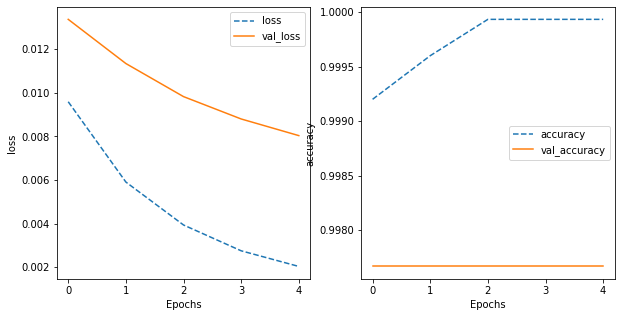

In [ ]:
training_plot(['loss', 'accuracy'], history_mobilenet)

In [ ]:
testAccuracy(mobilenet_model)

94/94 [==============================] - 7s 66ms/step

Test Accuracy: 99.87%



94/94 [==============================] - 6s 66ms/step


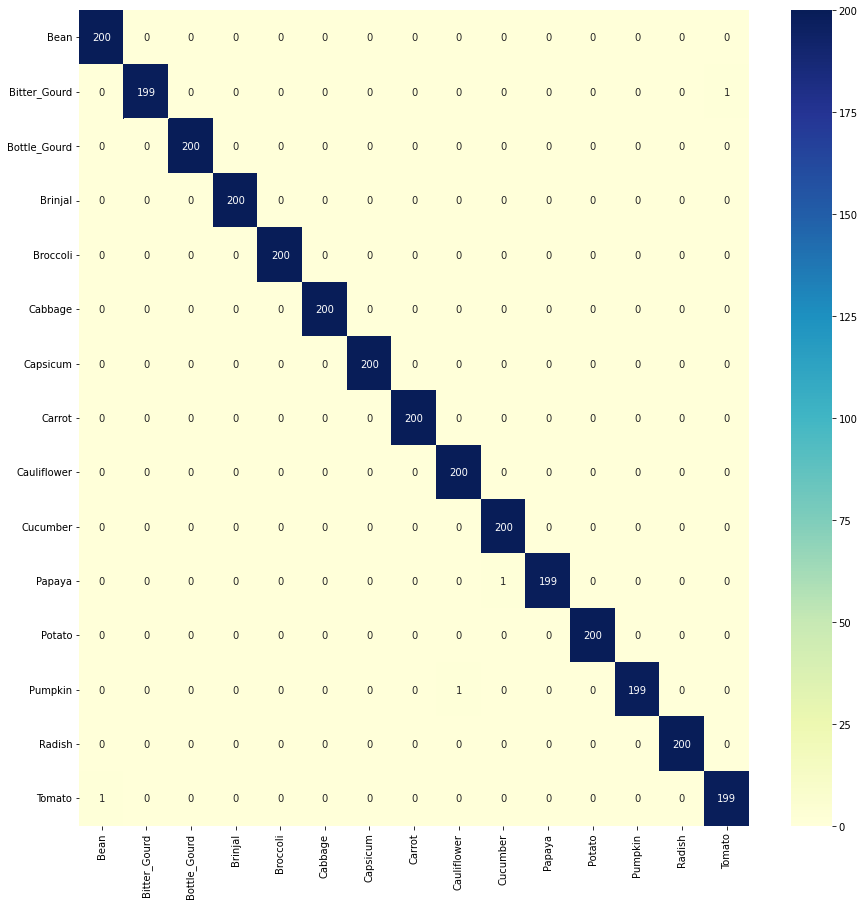

In [ ]:
ConfusionMatrix(mobilenet_model, test_ds, test_data.class_names)

Checking predictions with best models

94/94 [==============================] - 8s 88ms/step


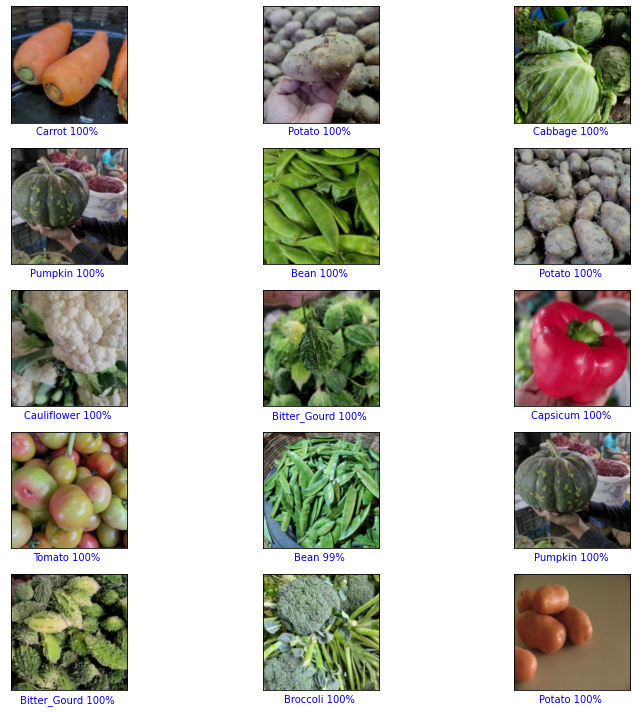

In [ ]:
predictions(resnet_model)

94/94 [==============================] - 6s 66ms/step


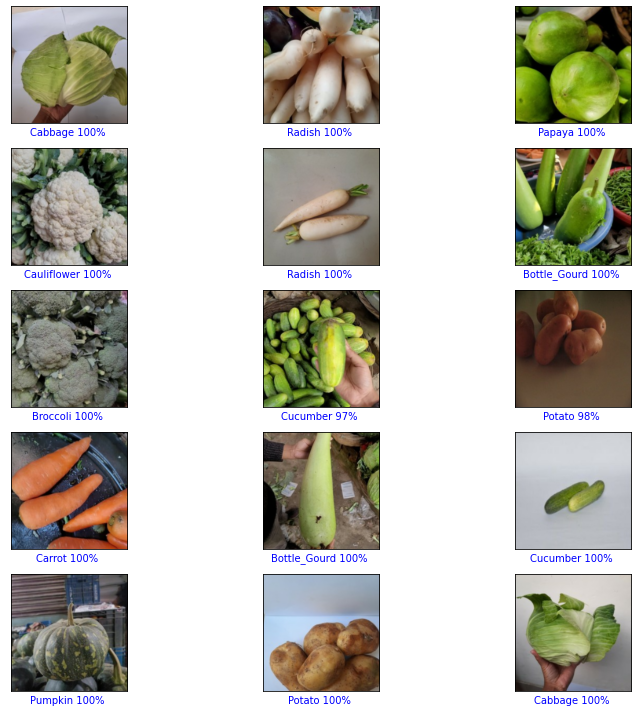

In [ ]:
predictions(mobilenet_model)

# Summary


Baseline Model: The model itself is performing really well with the data set and giving 74% test accuracy.

Improved Baseline Model: By adding more depth to the model and adding Batchnormalization and Dropout layers with early stopping the model exceptionally well with test accuracy above 90%.

Transfer Learning: All the models performed really well and test accuracy was exceptionally amazing with simple architecture like 

Mobilenet and surprisingly well with the naive model like VGG16.
